In [1]:
import os
import pandas as pd
import re
from IPython.display import display, HTML
import spacy
import en_core_web_lg
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer


##for clustering
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize

##To download packages directly from jupyter notebook
import sys ##execute the pip installs if you are running this for the first time
# !{sys.executable} -m pip install gensim
# !{sys.executable} -m pip install pyLDAvis

# display(HTML("<style>div.output_scroll { width: 80em; }</style>"))

%matplotlib inline  
import matplotlib.pyplot as plt

BASE_PATH = os.path.dirname(os.path.abspath('__file__'))
DATA_PATH = os.path.join(BASE_PATH, 'Data')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gaurikatyagi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gaurikatyagi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
RAW_DATA = None
for root, dirs, files in os.walk(DATA_PATH):
    for filename in files:
        RAW_DATA = os.path.join(DATA_PATH, filename)
        print("%s: %d bytes"%(filename, os.path.getsize(RAW_DATA)))
        print()

NOTEEVENTS.csv: 4007718005 bytes



# Reading the Data

Let us read only the first 1000 lines and understand the data that is given to us. Since it is such a big file, it will not load efficiently in excel

In [3]:
notes_data = pd.read_csv(RAW_DATA, nrows=1000)
display(HTML(notes_data.head(2).to_html()))

For this preliminary exercise we will only be looking at the Text. Let us get rid of everything extra at this point and maintain just the ROW_ID and TEXT

In [4]:
columns_to_drop = [ col for col in notes_data.columns if not (col == 'ROW_ID' or col =='TEXT')]
print("Columns to drop: ", columns_to_drop)
notes_data.drop(columns=columns_to_drop, inplace=True)
notes_data = notes_data.set_index('ROW_ID')

Columns to drop:  ['SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME', 'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR']


In [5]:
display(HTML(notes_data.head(2).to_html()))

Things we immediately notice:

1. This is plain text with no markups. If it did have markups, we could have used libraries such as [beautiful soup]( https://www.pythonforbeginners.com/beautifulsoup/beautifulsoup-4-python) 
2. The lines are artificially wrapped with new lines (whenever you se a single \n)
3. Are there any typos? We'll see more when we progress further
4. There’s punctuation like commas, apostrophes, quotes, question marks, and more.There is even acronyms
5. There’s hyphenated descriptions like “FOLLOW-UP”
6. There is usage of a lot of sequenced data and hence the appearance of '1.', '2.' and so on. But, notice how there is actually a single line brake even before thes numbers (like in 2)
7. See how the de-identified names are all replaced with the likes of 'Last Name' or 'First Name3', 'Hospital Ward Name' Good thing is these are all on square brackets and easy to identify. These are also always followed by paranthesis. Yay! something we can remove in the beginning iteslf!
8. Notice how dates might be required to handle (if they are all not in the same format)
9. Notice some formatting: such as : \n\n*******************\n\n or n??????\tT. We will need to handle all of this

In [6]:
def clean_text(x):
    x = " ".join(x.split())
    x= " ".join((" ".join(x.split("[**"))).split("**]"))
    x = re.sub(r"\([^()]*\)", "", x)
    key_value_strip =(x.split(":"))
    ##remove all sub strings which have a length lesser than 50 characters
    string = " ".join([sub_unit for sub_unit in key_value_strip if len(sub_unit)>50])
    x = re.sub(r"(\d+)+(\.|\))", "", string)## remove all serialization eg 1. 1)
    x = re.sub(r"(\*|\?|=)+", "", x) ##removing all *, ? and =
    x = re.sub(r"\b(\w+)( \1\b)+", r"\1", x) ## removing consecutive dupicate words
    x = x.replace("FOLLOW UP", "FOLLOWUP")
    x = x.replace("FOLLOW-UP", "FOLLOWUP")
    x = re.sub(r"(\b)(f|F)(irst)(\b)?[\d\-\d]*(\s)*(\b)?(n|N)(ame)[\d\-\d]*(\s)*[\d\-\d]*(\b)","",x)##remove firstname
    x = re.sub(r"(\b)(l|L)(ast)(\b)?[\d\-\d]*(\s)*(\b)?(n|N)(ame)[\d\-\d]*(\s)*[\d\-\d]*(\b)", "", x)
    x = re.sub(r"(\b)(d|D)\.?(r|R)\.?(\b)", "", x) #remove Dr abreviation
    x = re.sub(r"([^A-Za-z0-9\s](\s)){2,}", "", x)##remove consecutive punctuations
    

    return(x.replace("  ", " "))


notes_data["TEXT"] = notes_data["TEXT"].apply(lambda x: clean_text(x))

display(HTML(notes_data.head(2).to_html()))

Let us find all capital words in the entire document to see what all sections we can identify to summarize. We will reduce the massive list of "potential topics" based on domain knowledge of what words might be acronyms.

After that, we will save the potential topics to a flat file and manually tag them as "T" or "F". Then, load this file back and perform further analysis.

In [7]:
topics =notes_data["TEXT"].apply(lambda text:list(filter(None,[x.strip() for x in re.findall(r"\b[A-Z\s]+\b",text)])))
topics = topics.tolist() 
#combine all items from topics and find unique elements 
topics = sorted(set([sub_topic.strip() for topic in topics for sub_topic in topic]))
print("Number of unique topics identified: ",len(topics))

##We remove all words from the topics list which had a high potential to be an acronym
topics = [topic for topic in topics if (len(topic.split())>2) or (len(topic.split())<2 and len(topic)>4)]
print("Unique Eligible topics: ", len(topics))
pd.DataFrame(topics, columns=['topics']).to_csv(os.path.join(BASE_PATH, "potential_topics.csv"), index = False)


Number of unique topics identified:  5608
Unique Eligible topics:  2259


In [8]:
topics = pd.read_csv(os.path.join(BASE_PATH, "potential_topics_CODED.csv"))

topics = (topics[topics.accepted != 'F'])
print(topics.shape)

topics.drop(columns='accepted',inplace=True)
topics= topics["topics"].tolist()
print(topics)

(124, 2)
['ABNORMALITY', 'ACTIVE PROBLEMS BY ISSUES', 'ADDITIONAL HOSPITAL COURSE', 'ADMISSION LABORATORY DATA', 'ADMISSION LABS', 'ALLERGIES', 'ASSESSMENT', 'ASSESSMENT AND PLAN', 'AVOID', 'MEDICATIONS ON ADMISSION', 'BACKGROUND', 'BLOOD CULTURE FINAL REPORT', 'BRIEF SUMMARY OF HOSPITAL COURSE', 'CALL YOUR SURGEON IMMEDIATELY IF YOU EXPERIENCE ANY OF THE FOLLOWING', 'CHANGES TO YOUR MEDICATIONS', 'CLEAN CATCH FINAL REPORT', 'COMMENTS', 'COMMUNICATION', 'COMPARISON', 'COMPARISONS', 'COMPLICATIONS', 'CONCISE SUMMARY OF HOSPITAL COURSE', 'CONCISE SUMMARY OF HOSPITAL COURSE BY ISSUE', 'CONCLUSION', 'CONDITION', 'CONDITION AT DISCHARGE', 'CONDITION AT THE TIME OF DISCHARGE', 'CONDITION ON DISCHARGE', 'CONDITION ON TRANSFER', 'CONTRAINDICATIONS', 'COURSE IN HOSPITAL', 'CXR FINDINGS AP', 'CXR REASON FOR EXAMINATION', 'DECREASE', 'DESCRIPTION OF PROCEDURE', 'DISCHARGE EXAM PHYSICAL EXAMINATION VITALS', 'DISCHARGE PHYSICAL EXAMINATION', 'DISCHARGE MEDICATION', 'DO NOT GIVE UNTIL TROUGH HAS BEE

#### Now, we will change the case of all CAPITAL words to lower case, unless they are the topics identified above

1. Find the Lemma for all the above topics by running it through stemmers 
We remove stop words within topics to catch more topics in the "capitalized list of word". For now, we will not try identify our topics in other non-capitalized words because all chart notes have followed the trend of CAPITALIZED words for sections

In [9]:
nlp = en_core_web_lg.load()
stemmer = SnowballStemmer(language='english')


In [10]:
lemmatized_topics_values =[]
lemmatized_topics_index = []
index = 0

for doc in nlp.pipe(topics):
##         Confirming that lemmatization is working as expected
#     for token in doc:
#         if token.text.lower()!= token.lemma_.lower():
#             print(token.text, token.lemma_)
    lemmatized_topics_values.append(' '.join(
                                [token.lemma_.strip().lower() for token in doc if not nlp.vocab[token.text].is_stop]
                                            ).strip().upper())
    lemmatized_topics_index.append(stemmer.stem(lemmatized_topics_values[index].lower()))
    index +=1

This is how the lemmatization and the stemmed index for more comprehensive matching looks:

In [11]:
for index in range(len(lemmatized_topics_index)):
    print("Original Topic: %s \n New Topic Index: %s\n New Topic value: %s"%(topics[index], 
                                                                             lemmatized_topics_index[index],
                                                                             lemmatized_topics_values[index]))
    ##you can remove this to see all pairs
    if index>2:
        break
    print("\n\n")

    

Original Topic: ABNORMALITY 
 New Topic Index: abnorm
 New Topic value: ABNORMALITY



Original Topic: ACTIVE PROBLEMS BY ISSUES 
 New Topic Index: active problem issu
 New Topic value: ACTIVE PROBLEM ISSUE



Original Topic: ADDITIONAL HOSPITAL COURSE 
 New Topic Index: additional hospital cours
 New Topic value: ADDITIONAL HOSPITAL COURSE



Original Topic: ADMISSION LABORATORY DATA 
 New Topic Index: admission laboratory datum
 New Topic value: ADMISSION LABORATORY DATUM


2. Compare the stem of every topic's and change it to lower if it does not match to stem of lemmatized topics.

Why lemmatize first and then match only of the stem?
Because, lemmatization is done based on what Part of Speech the word falls in. However, stemming is just trying to find the root of the words by stripping out common plural(etc) alphabets.

So, we compare to the stemmed portion but, keep the lemmatized word of the identified topic as the final topic. This even allows us to get standardized topics across different chart notes

In [12]:
def toLower(text):
    matches = re.findall(r"\b[A-Z\s]+\b",text)
    non_matches = re.split(r"\b[A-Z\s]+\b",text) ## see what happens with re.split(r"\b[A-Z\s]+\b",text)
#     print((non_matches))
    for index, match in enumerate(matches):
        if match.strip() == '' or match.strip() == ' ':
            matches[index] = non_matches[index]
        elif len(match.split())>1: ## look for stop word only if the possible topic has more than 1 word
            match_cleaned = ' '.join(
                            [word for word in match.lower().strip().split() if not nlp.vocab[word.lower()].is_stop]
                                    )
            doc = nlp(match_cleaned)
            match_cleaned = ' '.join([token.lemma_ for token in doc])          
            if stemmer.stem(match_cleaned.strip()) in lemmatized_topics_index:
                matches[index] = lemmatized_topics_values[lemmatized_topics_index.index(
                                                                                stemmer.stem(match_cleaned.strip())
                                                                                        )
                                                         ]
            else:
                matches[index] = match.lower()
        elif len(match.split())==1:
            match_cleaned = match.lower().strip()
            doc = nlp(match_cleaned)
            match_cleaned = ' '.join([token.lemma_ for token in doc])          
            if stemmer.stem(match_cleaned.strip()) in lemmatized_topics_index:
                matches[index] = lemmatized_topics_values[lemmatized_topics_index.index(
                                                                                stemmer.stem(match_cleaned.strip())
                                                                                        )
                                                         ]
            else:
                matches[index] = match.lower()
    return(' '.join(matches))

notes_data["TEXT"] = notes_data["TEXT"].apply(lambda text: toLower(text))
display(HTML(notes_data.head(1).to_html()))


,TEXT
ROW_ID,
174,"Radiologic studies also included a ct , which confirmed cavitary lesions in the left lung apex consistent with infectious process/tuberculosis. This also moderate-sized left pleural head ct ct showed no intracranial hemorrhage or mass effect, but old infarction consistent with past medical abdominal ct ct showed lesions of T10 and sacrum most likely secondary to osteoporosis. These can be followed by repeat imaging as an m d md Number 1776 Dictated"


### Looking at what Spacy is finding in the new text

#### Entities

In [13]:
doc = nlp(notes_data["TEXT"][178])
text_label_df = pd.DataFrame({"label":[ent.label_ for ent in doc.ents], 
                                  "text": [ent.text for ent in doc.ents]
                                 })
# for ent in doc.ents:
    # print the entity text and label
    
display(HTML(text_label_df.head(10).to_html()))

#     print(ent.text, ent.label_)


,label,text
0,ORG,Hospital1 18
1,CARDINAL,10
2,GPE,Arthrodesis
3,DATE,82 year old
4,QUANTITY,approximately 10 feet
5,ORG,Hospital1 ct
6,GPE,Country
7,WORK_OF_ART,Family History Phycial
8,PERSON,SaO2
9,ORG,Abd


So, we understand the SPACY thinks "ct" is Connecticut and wants to label it as GPE, T10 is an ORG, and "secondary is ordinal data. But wait, what is "FAC"?

Also,
YEAH Spacy doesn't seem to be doing great with clinical text for POS. But, can it identify dependencies?


In [14]:
spacy.explain('FAC') ## ah like a facility etc. 

'Buildings, airports, highways, bridges, etc.'

In [15]:
# Process the text
doc = nlp(notes_data["TEXT"][174][:100])
print(notes_data["TEXT"][174][:100], "\n")
# Iterate over the tokens in the doc
for token in doc:
    if not (token.pos_ == 'DET' or token.pos_ == 'PUNCT' or token.pos_ == 'SPACE' or 'CONJ' in token.pos_):
        print(token.text, token.pos_)
        print("lemma:", token.lemma_)
        print("dependency:", token.dep_, "- ", token.head.orth_)
        print("prefix:", token.prefix_)
        print("suffix:", token.suffix_)


 Radiologic studies also included a  ct , which confirmed cavitary lesions in the left lung apex con 

Radiologic ADJ
lemma: radiologic
dependency: amod -  studies
prefix: R
suffix: gic
studies NOUN
lemma: study
dependency: nsubj -  included
prefix: s
suffix: ies
also ADV
lemma: also
dependency: advmod -  included
prefix: a
suffix: lso
included VERB
lemma: include
dependency: ROOT -  included
prefix: i
suffix: ded
ct NOUN
lemma: ct
dependency: dobj -  included
prefix: c
suffix: ct
confirmed VERB
lemma: confirm
dependency: relcl -  ct
prefix: c
suffix: med
cavitary NOUN
lemma: cavitary
dependency: compound -  lesions
prefix: c
suffix: ary
lesions NOUN
lemma: lesion
dependency: dobj -  confirmed
prefix: l
suffix: ons
in ADP
lemma: in
dependency: prep -  lesions
prefix: i
suffix: in
left ADJ
lemma: left
dependency: amod -  con
prefix: l
suffix: eft
lung NOUN
lemma: lung
dependency: compound -  apex
prefix: l
suffix: ung
apex PROPN
lemma: apex
dependency: compound -  con
prefix: a
suffix: 

Spacy still does pretty well in identifying the dependencies and hirerachy of the text.

### Summarize the text

This is inpired from a snippet of text I found online.

In [16]:
SUBJECTS = ["nsubj", "nsubjpass", "csubj", "csubjpass", "agent", "expl"]
OBJECTS = ["dobj", "dative", "attr", "oprd"]

def subjects_from_conjunction(subjects):
    additional_subjects= []
    for subject in subjects:
        # get everything to the right of the subject
        rights = list(subject.rights)
        right_dendencies = {token.lower_ for token in rights}
        if "and" in right_dendencies:
            additional_subjects.extend([token for token in rights if token.dep_ in SUBJECTS or token.pos_ == "NOUN"])
            if len(additional_subjects) > 0:
                additional_subjects.extend(subjects_from_conjunction(additional_subjects))
#         print("Additional Subjects:", additional_subjects)
    return additional_subjects

def objects_from_Conjunctions(objects):
    additional_objects= []
    for object in objects:
        # get everything to the right of the object
        rights = list(object.rights)
        right_dendencies = {token.lower_ for token in rights}
        if "and" in right_dendencies:
            additional_objects.extend([token for token in rights if token.dep_ in OBJECTS or token.pos_ == "NOUN"])
            if len(additional_objects) > 0:
                additional_objects.extend(objects_from_Conjunctions(additional_objects))
#     print("Objects from Conjunctions:", additional_objects)
    return additional_objects

def findSubjects(token):
    head = token.head
    while head.pos_ != "VERB" and head.pos_ != "NOUN" and head.head != head:
        head = head.head
    if head.pos_ == "VERB":
#         print("verb heads:", head)
        subjects = [tok for tok in head.lefts if tok.dep_ == "SUB"]
        if len(subjects) > 0:
            verb_is_negated = isNegated(head)
            subjects.extend(subjects_from_conjunction(subjects))
            return subjects, verb_is_negated
        elif head.head != head:
            return findSubjects(head)
    elif head.pos_ == "NOUN":
#         print("noun heads:", head)
        return [head], isNegated(token)
    return [], False

def isNegated(token):
    negations = {"no", "not", "n't", "never", "none", "dont"}
    for dep in list(token.lefts) + list(token.rights):
        if dep.lower_ in negations:
            return True
    return False

def objects_from_prepositions(dependencies):
    objects = []
    for dependency in dependencies:
        if dependency.pos_ == "ADP" and dependency.dep_ == "prep":
            objects.extend([token for token in dependency.rights if token.dep_  in OBJECTS or 
                                                     (token.pos_ == "PRON" and token.lower_ == "me")
                        ])
#     print("objects from prepositions:", objects)
    return objects


def all_subjects(verb):
    verbNegated = isNegated(verb)
    subjects = [token for token in verb.lefts if (token.dep_).lower() in SUBJECTS and token.pos_ != "DET"]
#     print()
#     print(verb, subjects)
    if len(subjects) > 0:
        subjects.extend(subjects_from_conjunction(subjects))
    else:
        foundSubjects, verbNegated = findSubjects(verb)
        subjects.extend(foundSubjects)
#     print("subjects, verb negated:", subjects, verbNegated)
    return subjects, verbNegated

def all_objects(v):
    # A right-child of the token= rights
    rights = list(v.rights)
    objetcs = [tok.head.orth_ for tok in rights if (tok.dep_).lower() in OBJECTS]
    objects = [tok for tok in rights if (tok.dep_).lower() in OBJECTS]
    
#     print("objects:", objects)
    objetcs.extend(objects_from_prepositions(rights))
    if len(objects) > 0:
        objetcs.extend(objects_from_Conjunctions(objects))
    return v, objects

def summarize(tokens):
    summary_ = []
    summary = []
    verbs = [token for token in tokens if token.pos_ == "VERB" and token.dep_ != "aux"]
#     print("verbs:", verbs)
    for verb in verbs:
        subjects, verbNegated = all_subjects(verb)
#         if len(subjects)>0:
#             print("\nSubjects, Verb ,Negations:", subjects, verb, verbNegated)

        # evaluate verb only if there are subjects
        if len(subjects) > 0:
            verb, objects = all_objects(verb)
#             print("Verb, Verb Negations:", verb, objects)
            for subject in subjects:
                for object in objects:
                    objNegated = isNegated(object)
                    summary_.append((subject.lower_, "NOT " + verb.lower_ if verbNegated or 
                                                                 objNegated 
                                                                else verb.lower_, object.lower_
                                ))
    for tuple_item in summary_:
        summary_item = " ".join(item for item in tuple_item)
        summary.append(summary_item)
    return ".".join(sentence for sentence in summary)

notes_data["SUMMARY"] = notes_data["TEXT"].apply(lambda text: summarize(nlp(text)))
notes_data["SUMMARY"] = notes_data["SUMMARY"].apply(lambda text: re.sub(r"(\b)(P|p)(t|T)(\b)", "patient", text))

In [17]:
display(HTML(notes_data.head(4).to_html()))


#### Find Words similar to a given Word

In [18]:
### words smilar to given word

from numpy import dot
from numpy.linalg import norm

exam = nlp.parser.vocab[u"exam"]

# cosine similarity
cosine = lambda v1, v2: dot(v1, v2) / (norm(v1) * norm(v2))

allWords = list({w for w in nlp.parser.vocab if w.has_vector and w.orth_.islower() and w.lower_ != "exam"})

# sort by similarity to Exam
allWords.sort(key=lambda w: cosine(w.vector, exam.vector))
allWords.reverse()
print("Top 5 most similar words to exam:")
for word in allWords[:5]:   
    print(word.orth_)
    

Top 5 most similar words to exam:
exams
examination
examinations
syllabus
certification


Wow!!! so does that mean we can even find similarities between documents? YES!! So, we can potentially find clusters of these different documents!!!!

In [19]:
doc1 = nlp(notes_data["TEXT"][1])
doc2 = nlp(notes_data["TEXT"][12])
print(doc1.similarity(doc2))

doc1 = nlp(notes_data["SUMMARY"][175])
doc2 = nlp(notes_data["SUMMARY"][176])
print(doc1.similarity(doc2))

0.9728900276696754
0.8604248967641884


In [20]:
# print(nlp(notes_data["TEXT"][1]))
# print("\n \n")
# print(nlp(notes_data["TEXT"][12]))


In [21]:
# print(nlp(notes_data["SUMMARY"][1]))
# print("\n \n")
# print(nlp(notes_data["SUMMARY"][12]))

## Cluster documents 

We will not do any preprocessing because we have essentially preprocessed when cleaning the text initially and only have phrases in Summary.

In [22]:
from gensim.models import TfidfModel, LsiModel
from gensim.models.ldamodel import LdaModel
from gensim import matutils
from sklearn.cluster import KMeans

In [23]:
from collections import defaultdict
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

def tokenize(text):
    text_wordlist = []
    for x in re.split(r"([.,!?\s]+)", text):
        if x and x not in [".", " "] and x.lower() not in stop_words:
            text_wordlist.append(x)
    return(text_wordlist)


texts = list(notes_data["SUMMARY"].apply( lambda text: tokenize(text)))
                    
# print(texts)
                     
# frequency_dictionary = defaultdict(int)
# for text in texts:
#     for token in text:
#         frequency[token] += 1

#### Finding the Optimum Number of Topics

The latent Dirichlet allocation (LDA) is a Bayesian probabilistic model of text documents. It determines sets of observations from unobserved groups. Hence, explaining the similar parts of data.

Observations are words from documents.
Each document is a amalgamation of a small number of topics.
Each word's presence is attributable to one of the document's topics.

Now that the data is ready, we can run a batch LDA to discover the main topics in our document

In [24]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel

dictionary = corpora.Dictionary(texts)
# print(dictionary.id2token) ## to see the actual dictionary generated
corpus = [dictionary.doc2bow(text) for text in texts] ## document to bag of words

# fit LDA model
transcripts_topics = LdaModel(corpus=corpus,
                           id2word=dictionary,
                           num_topics=30,
                           alpha='auto', ##Learns an asymmetric prior from the corpus;
##1D array of length=number of expected topics that expresses our a-priori belief for the each topics’ probability.
                           passes=100 ##Number of passes through the corpus during training.
                             ) 
print(transcripts_topics)
# print out first 5 topics
for i, topic in enumerate(transcripts_topics.print_topics(5)):
    print ('%d: %s\n'%(i+1, topic))
    

LdaModel(num_terms=5993, num_topics=30, decay=0.5, chunksize=2000)
1: (21, '0.016*"given" + 0.010*"presents" + 0.010*"family" + 0.010*"inability" + 0.008*"denies" + 0.008*"repair" + 0.008*"dose" + 0.008*"nausea" + 0.008*"graft" + 0.008*"food"')

2: (5, '0.026*"patient" + 0.014*"left" + 0.012*"shortness" + 0.008*"given" + 0.008*"denies" + 0.008*"trouble" + 0.008*"included" + 0.006*"midline" + 0.006*"preference" + 0.006*"give"')

3: (7, '0.061*"patient" + 0.024*"given" + 0.020*"showed" + 0.018*"developed" + 0.013*"left" + 0.010*"requiring" + 0.007*"required" + 0.006*"received" + 0.006*"need" + 0.006*"denies"')

4: (28, '0.042*"patient" + 0.034*"left" + 0.012*"given" + 0.012*"received" + 0.009*"history" + 0.008*"showed" + 0.008*"po" + 0.008*"delayed" + 0.008*"underwent" + 0.008*"attending"')

5: (14, '0.118*"patient" + 0.061*"showed" + 0.046*"revealed" + 0.044*"underwent" + 0.018*"tolerated" + 0.017*"ray" + 0.017*"received" + 0.017*"catheterization" + 0.013*"procedure" + 0.012*"developed"

### Understanding the dictionary and its structure

In [25]:
##let us see how this dictionary corpus is saved 
print("This is the text BOW: %s\n"%texts[1])
print("This is how the above text is represented in a dictionary: ",(dictionary.doc2bow(texts[1], 
                                                                                        return_missing=True)
                                                                    ))
print("\nSo What does this mean? Let's compare it to the dictionary to understand:")

print_index = 0
for tuple_item in dictionary.doc2bow(texts[1], return_missing=True)[0]:
    print("word: %s ------>Frequency: %s"%(dictionary.id2token[tuple_item[0]],tuple_item[1] ))
    print_index+=1
    if print_index>3:
        break
        
##dictionary words can be displayed in both way!
# print("word is: ", str(dictionary[5]), "\n")
# print("word is: ", dictionary.id2token[5], "\n")

This is the text BOW: ['required', 'oxygen', 'order', 'maintain', 'saturation', 'abnormalities', 'represent', 'allergic', 'portion', 'demonstrated', 'evidence', 'patient', 'denies', 'angina', 'husband', 'known', 'neurologist', 'evidence', 'obscures', 'exam', 'strap', 'obscures', 'exam', 'gas', 'showed', 'ph', 'po2', 'demonstrates', 'hernia', 'po2', 'demonstrates', 'axis', 'hernia', 'left', 'lobe', 'ekg', 'shows', 'rhythm', 'given', 'q', '4h', 'fact', 'labored', 'breathing', 'order', 'improve', 'oxygenation', 'episode', 'showed', 'evidence', 'patient', 'received', 'course', 'fact', 'marked', 'rales', 'ventilation', 'needed', 'help', 'evaluation', 'showing', 'evidence', 'puffs', 'inhaled', 'b']

This is how the above text is represented in a dictionary:  ([(5, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 4), (22, 2), (23, 2), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 

In [26]:
# print(corpus) ##remove comments to see how a corpus looks([[word_index, frequency], [word_index, frequency]...])
print(corpus[13]) ##13th documents in the corpus
print(notes_data["SUMMARY"][13])
# Get the topic distribution for the given document.
display(transcripts_topics.get_document_topics(corpus[13],per_word_topics=True )) 
##This returns [(topic_id, topic_probability), 
##             [(text_index_indictionary, [topic_id])], 
##            [(text_index_indictionary, [topic_id])]
##            ]

##Explor the words that make up TOPIC-5
for item in (transcripts_topics.get_document_topics(corpus[13],per_word_topics=True ))[2]:
    print(dictionary.id2token[item[0]])


[(43, 1), (116, 1), (165, 1), (395, 1), (425, 1), (426, 1)]
patient given levaquin.they found obstruction.patient underwent surgery.patient underwent closure.elevations undergo rule.data revealed count.infiltrate prevent possibility.events include fibrillation.up anticipate course.events include bronchoscopy.patient remained afebrile.cultures grew streptococcus.they awaiting sensitivities.patient providing direction.patient remained afebrile.day include fibrillation.patient remained afebrile.patient underwent ct.perspective continue regimen.patient spikes fever.patient remained afebrile.patient remained afebrile.events include times.patient remained afebrile.bun glucose patient.events included fibrillation.patient remained afebrile.bid keep inr


([(13, 0.33743757), (14, 0.60278946)],
 [(43, [14, 13]),
  (116, [14, 13]),
  (165, [13]),
  (395, [14]),
  (425, [13]),
  (426, [14])],
 [(43, [(13, 0.15301548), (14, 0.84698313)]),
  (116, [(13, 0.012965544), (14, 0.98702985)]),
  (165, [(13, 0.99979717)]),
  (395, [(14, 0.9999689)]),
  (425, [(13, 0.99979717)]),
  (426, [(14, 0.9999628)])])

patient
underwent
revealing
disease
male
times


<b>That was fun, wasn't it. Now, let us visialuze all the topics we extracted. </b>

In [27]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis
vis_data = gensimvis.prepare(transcripts_topics, corpus, dictionary)
pyLDAvis.display(vis_data)

<b>This shows that topics are getting assigned based on the disease/condition being talked about. Great, let us see the topic propensity among the transcripts</b>

In [28]:
# extract all document-topic distritbutions to dictionnary
document_key = list(notes_data.index) ##get index of transcripts for topic in each
document_topic = {}
for doc_id in range(len(corpus)):
    docbok = corpus[doc_id]
    doc_topics = transcripts_topics.get_document_topics(docbok, 0)
    tmp = []
    for topic_id, topic_prob in doc_topics:
        tmp.append(topic_prob)
    document_topic[document_key[doc_id]] = tmp
# convert dictionnary of document-topic distritbutions to dataframe
df = pd.DataFrame.from_dict(document_topic, orient='index')
topic_column_names = ['topic_' + str(i) for i in range(0, 30)]
df.columns = topic_column_names
df['SUMMARY'] = (notes_data['SUMMARY'])

display(HTML(df.head(5).to_html()))


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,SUMMARY
174,0.001418,0.000982,0.000950,0.000832,0.001069,0.000692,0.001303,0.002064,0.001217,0.000750,0.000769,0.001705,0.000762,0.001238,0.005002,0.000865,0.001082,0.000808,0.963770,0.001084,0.000848,0.000678,0.002054,0.001188,0.000847,0.000989,0.001007,0.000917,0.002201,0.000907,studies included ct.ct confirmed lesions.ct NOT showed hemorrhage.ct showed lesions
175,0.000270,0.000187,0.000181,0.000158,0.000204,0.000132,0.000248,0.000393,0.000232,0.000143,0.000146,0.000325,0.000145,0.000236,0.000952,0.000165,0.000206,0.000154,0.000192,0.000206,0.000162,0.000129,0.000391,0.000226,0.000161,0.000188,0.993101,0.000175,0.000419,0.000173,she required oxygen.order maintain saturation.abnormalities represent allergic.portion NOT demonstrated evidence.patient denies angina.husband known neurologist.evidence obscures exam.strap obscures exam.gas showed ph.po2 demonstrates hernia.po2 demonstrates axis.hernia left lobe.ekg shows rhythm.she given q.4h.fact labored breathing.order improve oxygenation.episode NOT showed evidence.patient received course.fact marked rales.ventilation needed help.evaluation NOT showing evidence.puffs inhaled b.i.d
176,0.000225,0.000156,0.000151,0.000132,0.000170,0.000110,0.000207,0.000328,0.000193,0.000119,0.000122,0.000271,0.000121,0.000197,0.000795,0.000137,0.000172,0.000128,0.000160,0.000172,0.994219,0.000108,0.000326,0.000189,0.000135,0.000157,0.000160,0.000146,0.000350,0.000144,she had difficulties.she required intubation.she required narrowing.she underwent placement.collapse forced expiration.she noticed improvement.she describes years.she notices it.ped struck injury.exacerbation requiring tracheobronchomalacia.bronchial stenting hernia.edema clubbing hospital.female admitted 4.hypoxia requiring resulting.patient used pca.patient used control.patient required intubation.c'd weaning trial.c'd weaning trial.aggitation inhibiting efforts.bronch revealed epiglottis.peep5 initiated placement.vancomycin started op.hypertension controlled iv.midline placed 9.trach form portex.trach changed trach.give recommend eval.days eliminate chin
177,0.000185,0.000128,0.000124,0.000109,0.000140,0.000090,0.000170,0.000270,0.000159,0.000098,0.000100,0.000223,0.000099,0.000162,0.000653,0.000113,0.000141,0.000105,0.000132,0.000142,0.000111,0.000089,0.000268,0.000155,0.000111,0.000129,0.000132,0.000120,0.995424,0.000118,patient developed worsening.ems found tachypnic.she given nebulizer.husband experiencing symptoms.she experiencing symptoms.patient saturating nrb.cxr NOT reveal consolidation.evaluation revealed leukocytosis.14 received nebs.lactate received nebs.patient became tachpnic.patient appeared comfortable.tracheobronchoplasty performed cad.ped struck injury.imaging suggests ventricular.space represents impression.leukocytosis supports pneumonia.culture grew type.bronchoscopy revealed airways.she NOT want tracheostomy.exams revealing overload.she experienced shortness.patient continue mg.they recommended history.statin held aspirin.she NOT want tracheostomy.she would dnr.she deemed suitable.insulin sliding scale.you underwent bronchoscopy.you developed gastrointestinal.you underwent procedure.you continue taper.you call doctor.mg start colace.mg use morphine
178,0.000266,0.000184,0.000178,0.000156,0.000201,0.000130,0.000244,0.000387,0.000228,0.000141,0.000144,0.000320,0.000143,0.000232,0.000938,0.000162,0.000203,0.000151,0.000189,0.993219,0.000159,0.000127,0.000385,0.000223,0.000159,0.000186,0.000189,0.000172,0.000413,0.000170,scan revealed fracture.spine involving pedicle.spine left lamina.lucency represent injury.abdomen pelvis impression.spine performed ct.considerations include sequela.thrombosis involve veins.portion suggests cardiomegaly.lesion representin

## a) Clustering by Assigning Final Topics to Transcripts

In [29]:
def find_topic(row):
    if (row.loc[row>0.9]).any():
        return row.loc[row>0.9].index[0]
    else:
        return None
    
def find_propensity(row):
    if (row.loc[row>0.9]).any():
        return row.loc[row>0.9].values[0]
    else:
        return None
    
df['topic'] = df.loc[:, df.columns !='SUMMARY'].apply(find_topic, axis = 1)
df['propensity'] = df.iloc[:, 0:29].apply(find_propensity, axis = 1)

In [30]:
df.drop(columns=df.columns[:30], inplace=True)

In [31]:
display(df.head())

,SUMMARY,topic,propensity
174,studies included ct.ct confirmed lesions.ct NO...,topic_18,0.963770
175,she required oxygen.order maintain saturation....,topic_26,0.993101
176,she had difficulties.she required intubation.s...,topic_20,0.994219
177,patient developed worsening.ems found tachypni...,topic_28,0.995424
178,scan revealed fracture.spine involving pedicle...,topic_19,0.993219


In [32]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: left;
    vertical-align: left;
}
</style>
""")

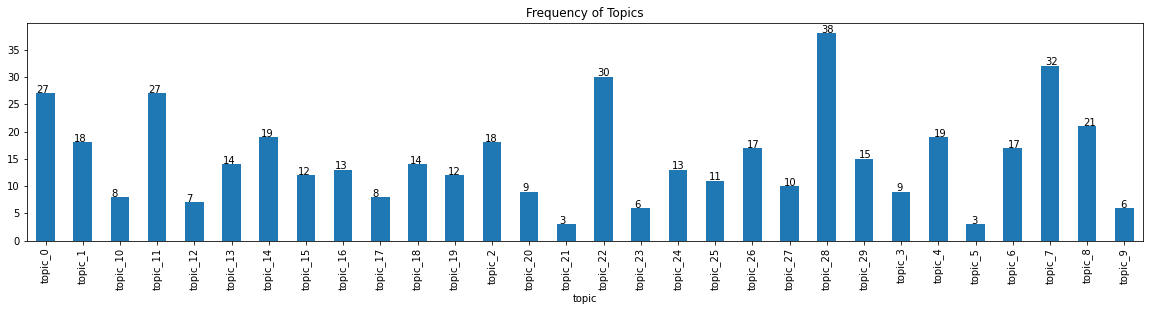

In [33]:
# fig = plt.figure(figsize=(10,4))
plt.rcParams["figure.figsize"] = (20,4)

topic_frequency = df.iloc[:, :2].groupby('topic').count()
ax = topic_frequency.plot.bar( legend=False)
plt.title("Frequency of Topics", size=12)
# plt.xticks(rotation=45)
ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)


for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

## b) Clustering using unsupervised learning to find most optimal clusters in these 30 topics

In [81]:
topics_all = pd.DataFrame.from_dict(document_topic, orient='index')
topic_column_names = ['topic_' + str(i) for i in range(0, 30)]
topics_all.columns = topic_column_names
topics_all.to_csv(os.path.join(BASE_PATH, "topic_propensities.csv"))

# print(topics_all.describe())
display(topics_all.head())

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29
174,0.001418,0.000982,0.000950,0.000832,0.001069,0.000692,0.001303,0.002064,0.001217,0.000750,...,0.000848,0.000678,0.002054,0.001188,0.000847,0.000989,0.001007,0.000917,0.002201,0.000907
175,0.000270,0.000187,0.000181,0.000158,0.000204,0.000132,0.000248,0.000393,0.000232,0.000143,...,0.000162,0.000129,0.000391,0.000226,0.000161,0.000188,0.993101,0.000175,0.000419,0.000173
176,0.000225,0.000156,0.000151,0.000132,0.000170,0.000110,0.000207,0.000328,0.000193,0.000119,...,0.994219,0.000108,0.000326,0.000189,0.000135,0.000157,0.000160,0.000146,0.000350,0.000144
177,0.000185,0.000128,0.000124,0.000109,0.000140,0.000090,0.000170,0.000270,0.000159,0.000098,...,0.000111,0.000089,0.000268,0.000155,0.000111,0.000129,0.000132,0.000120,0.995424,0.000118
178,0.000266,0.000184,0.000178,0.000156,0.000201,0.000130,0.000244,0.000387,0.000228,0.000141,...,0.000159,0.000127,0.000385,0.000223,0.000159,0.000186,0.000189,0.000172,0.000413,0.000170


Let us visualize the hierarchy of these topics within chart notes. And try idenifying the number of clusters we would need.This can be done in 2 ways- <br>
i. Visualization OR <br>
ii. Elbow Method <br>
iii. Gridsearch- it would have been great had we had target values-y labels. But, since we do not, we will skip this one.

#### i. Visualization

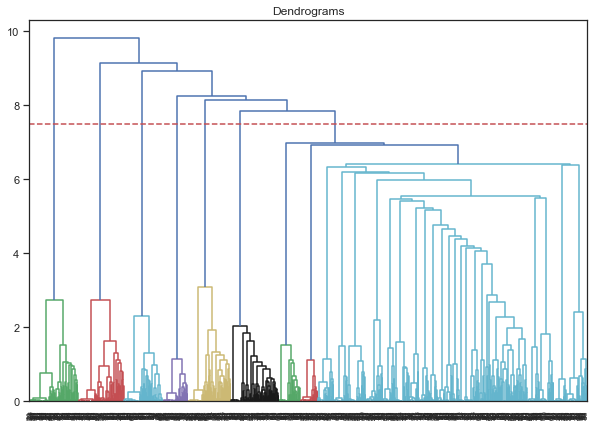

In [82]:
from scipy.cluster import hierarchy
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = hierarchy.dendrogram(hierarchy.linkage(topics_all, method='ward'))
plt.axhline(y=7.5, color='r', linestyle='--')


The x-axis contains the samples and y-axis represents the distance between these samples. The vertical line with maximum distance is the blue line and hence we can decide a threshold of 7.5 and cut the dendrogram at that point(horizontal dotted line).

We have 7 clusters as this line cuts the dendrogram at 7 points. Let’s now apply hierarchical clustering for these clusters.

Before we cluster. We should know what parameters you are chosing and why:
LINKAGE determines which distance to use between sets of observation. The algorithm merges  pairs of cluster that minimize the chosen criteria. 
1. <b>ward</b> minimizes the variance of the clusters being merged.
2. <b>average</b> uses the average of the distances of each observation of the two sets.
3. <b>complete or maximum linkage</b> uses the maximum distances between all observations of the two sets.
4. <b>single</b> uses the minimum of the distances between all observations of the two sets.

I want to minimize the variance between the merged clusters. Now, I can ony use <b> Euclidean distance </b>

In [78]:
from sklearn.cluster import AgglomerativeClustering
cluster_model = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')  
cluster = cluster_model.fit_predict(topics_all).tolist()
# print(type(cluster))
topics_all["cluster"] = cluster

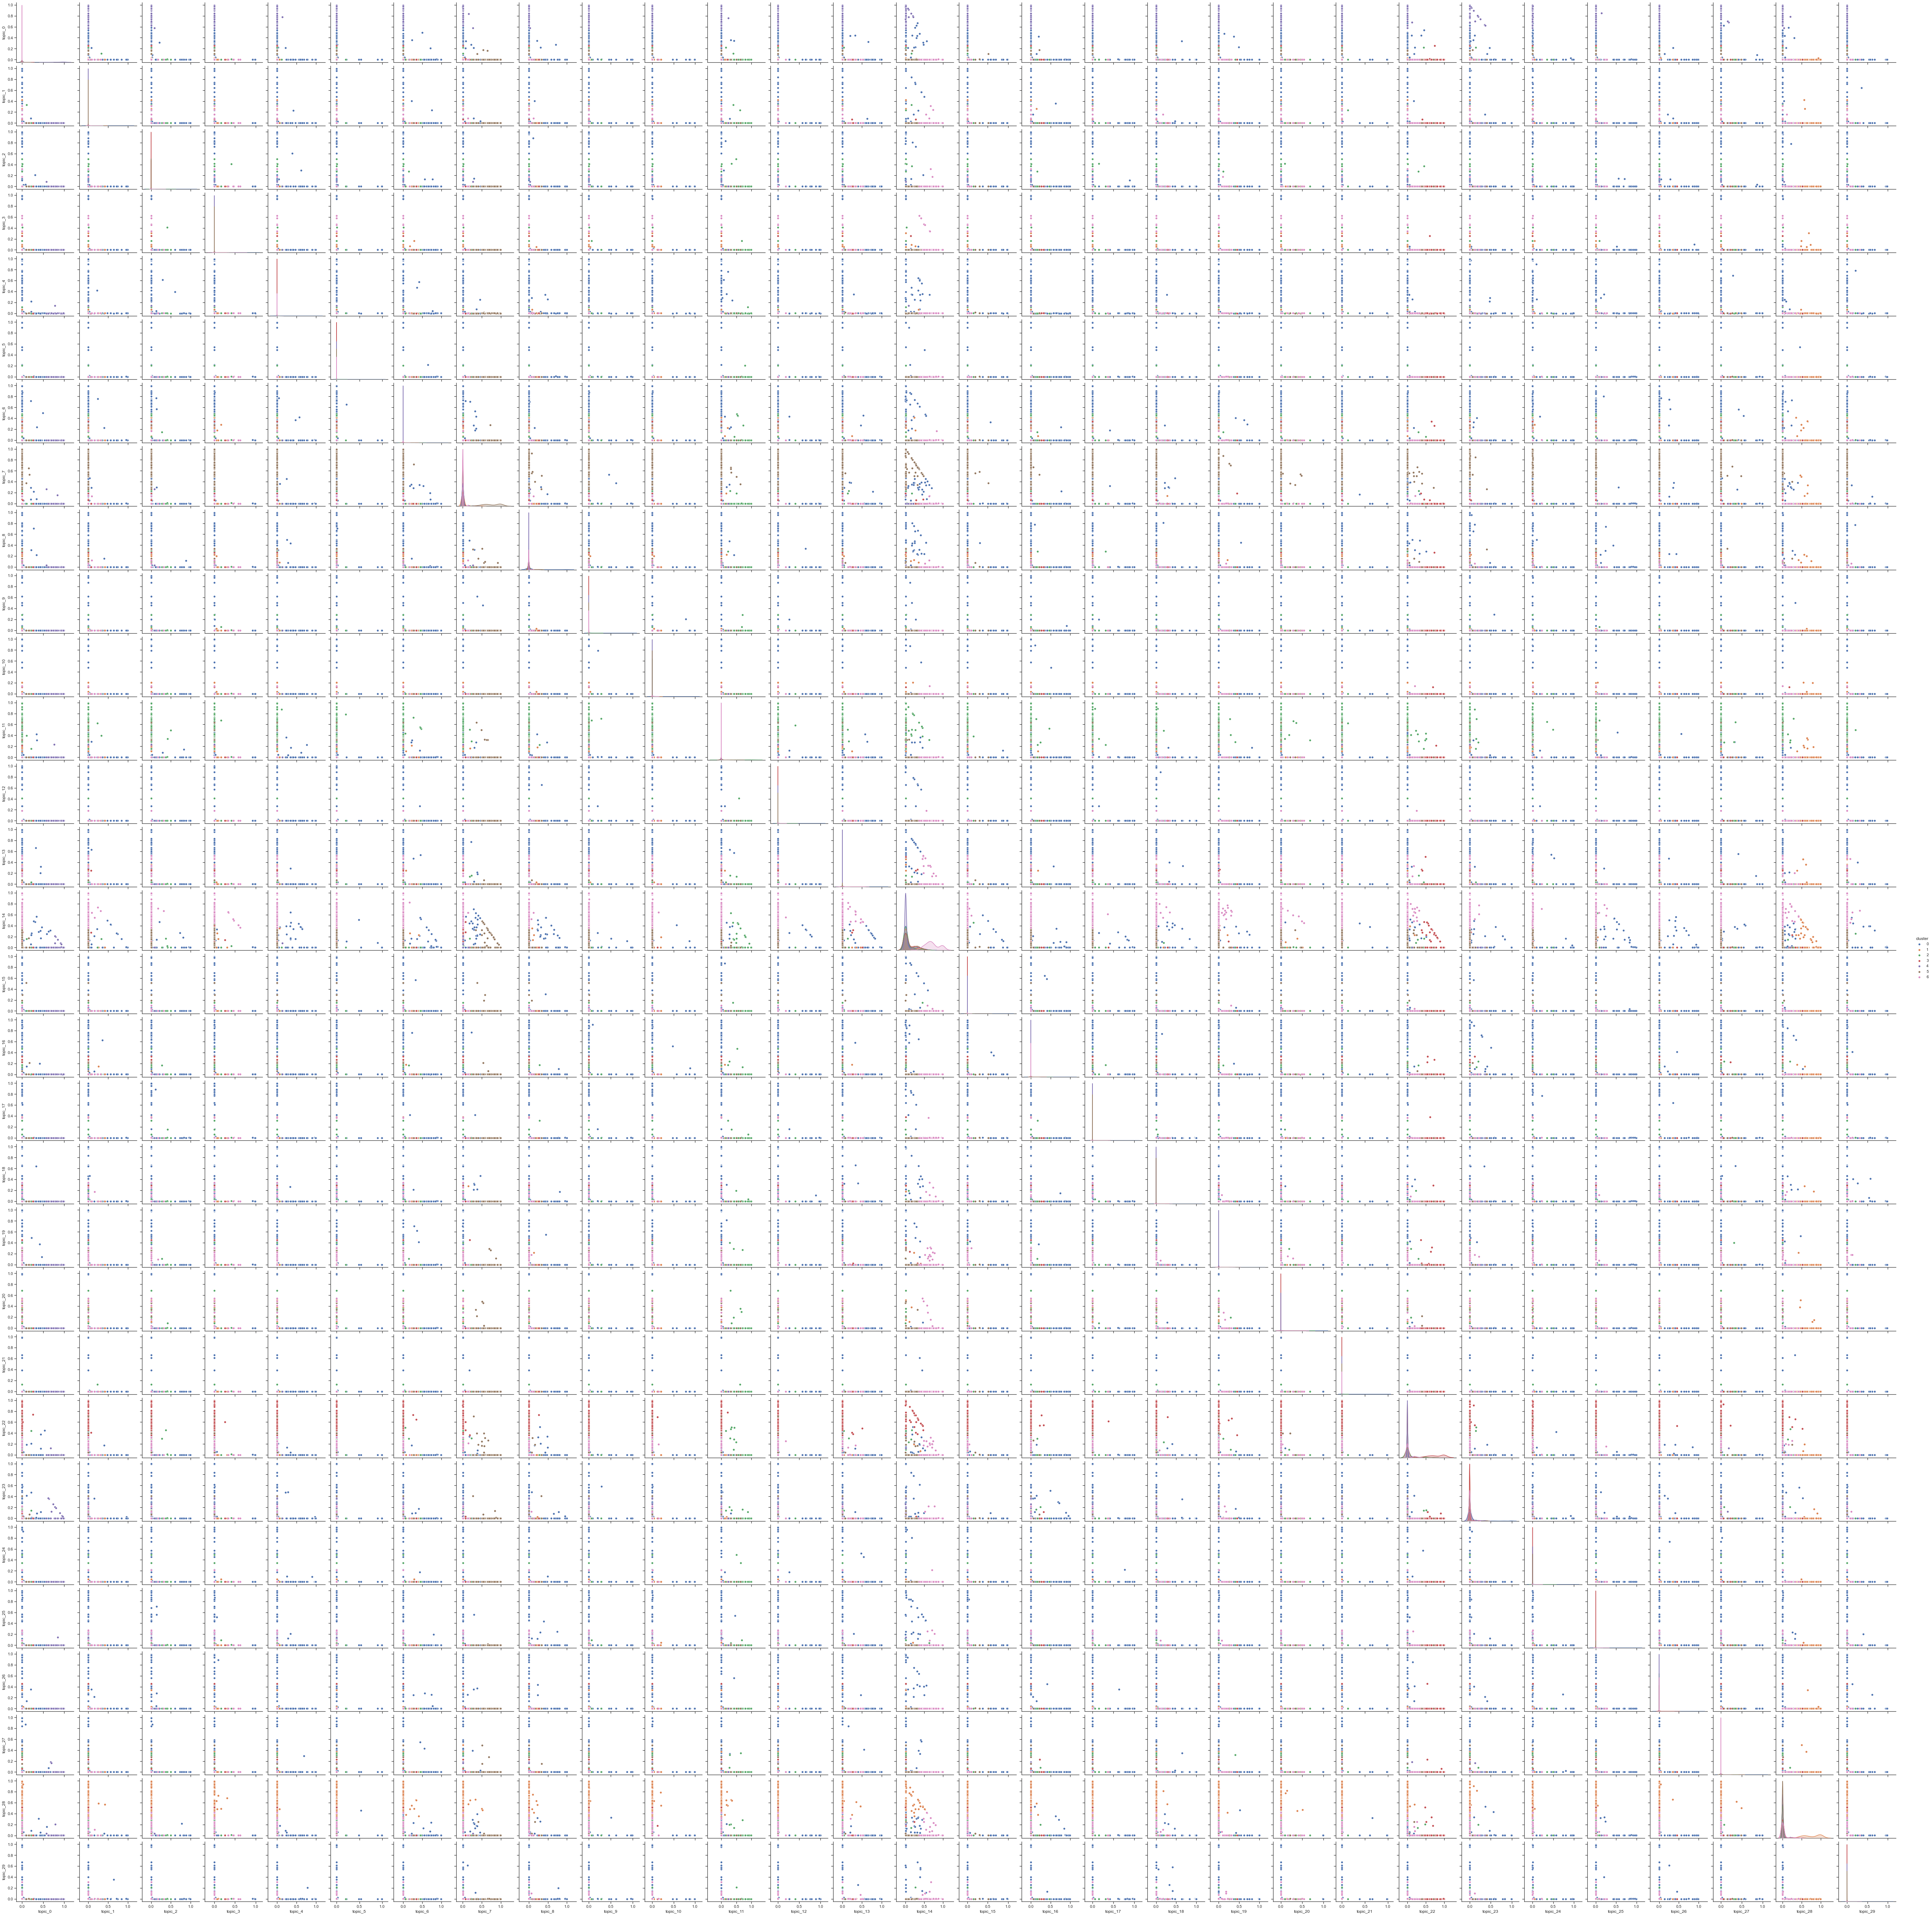

In [79]:
# !{sys.executable} -m pip install seaborn
import seaborn as sns; sns.set(style="ticks", color_codes=True)
g = sns.pairplot(topics_all, hue="cluster")

# plt.scatter(data_scaled['Milk'], data_scaled['Grocery'], c=cluster.labels_) 

#### ii. Gridsearch

We will now use kmeans' inertial drop to find the optimum numbe of clusters.

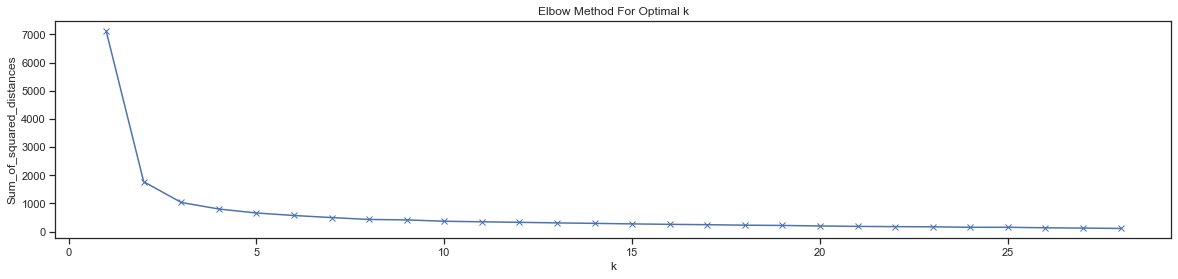

In [73]:
from sklearn.cluster import KMeans
Sum_of_squared_distance = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(topics_all)
    Sum_of_squared_distance.append(km.inertia_)
plt.plot(K, Sum_of_squared_distance, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distance')
plt.title('Elbow Method For Optimal clusters')
plt.show()

The elbow drops to an almost flat between 6 and 7. 

Hence, we can see that both hierarchical and kmeans gave similar results.